# Scraping de propiedades en mapainmueble.com

Este notebook realiza un scraping de propiedades de alquiler en el sitio **mapainmueble.com**.
Se recopilan detalles como título, enlace, imagen, ubicación, precio, número de habitaciones, baños, tamaño, y parqueos.

El código utiliza las siguientes bibliotecas:

- `requests`: Para realizar peticiones HTTP al sitio web.
- `BeautifulSoup`: Para analizar y extraer datos del HTML.
- `csv`: Para guardar los datos extraídos en un archivo CSV.
- `time`: Para manejar pausas entre peticiones y evitar bloqueos.

El scraping recorre varias páginas del sitio y obtiene la información de cada propiedad listada.



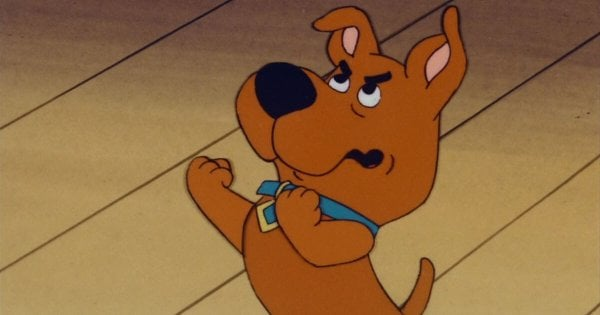



## Juan Diego Letona Aguilar, 20230285

In [1]:
import requests  #importa la librería requests para hacer peticiones http
from bs4 import BeautifulSoup  #importa beautifulsoup para analizar el html
import csv  #importa csv para guardar los datos extraídos en un archivo csv
import time  #importa time para agregar pausas entre peticiones

#cabeceras para simular un navegador real al hacer las peticiones
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/90.0.4430.93 Safari/537.36"
}

In [2]:
#url base del sitio web que se va a scrapear
base_url = "https://mapainmueble.com/apartamentos-en-alquiler-zona-14/"

#genera una lista con las urls de las páginas a scrapear (de la 1 a la 8)
paginas = [base_url] + [f"{base_url}page/{i}/" for i in range(2, 9)]

#lista donde se almacenarán los datos de cada propiedad extraída
propiedades = []

In [3]:
#itera sobre cada url de la lista de páginas
for url in paginas:
    print(f"procesando página: {url}")  #muestra en consola la página que se está procesando
    try:
        #realiza la petición http a la página
        resp = requests.get(url, headers=headers, timeout=10)
        resp.raise_for_status()  #lanza un error si la respuesta no es exitosa
    except Exception as e:
        print(f"error al acceder a {url}: {e}")  #muestra el error si la petición falla
        continue  #continúa con la siguiente página

    #parsea el contenido html de la página con beautifulsoup
    soup = BeautifulSoup(resp.text, 'html.parser')
    
    #busca todas las propiedades en la página usando la clase css correspondiente
    items = soup.select("div.listing_wrapper")
    print(f"encontradas {len(items)} propiedades en {url}")  #muestra cuántas propiedades se encontraron
    
    #itera sobre cada propiedad encontrada
    for item in items:
        try:
            #extrae el id de la propiedad desde el atributo data-listid
            prop_id = item.get("data-listid", "na").strip()
            
            #extrae el título de la propiedad desde el atributo data-modal-title
            titulo = item.get("data-modal-title", "na").strip()
            
            #extrae el enlace de la propiedad desde el atributo data-modal-link
            enlace = item.get("data-modal-link", "na").strip()
            
            #extrae la imagen principal de la propiedad desde el atributo data-main-modal
            imagen_principal = item.get("data-main-modal", "na").strip()
            
            #busca el div que contiene el número de cámaras de la propiedad
            media_div = item.select_one("div.property_media")
            camaras = media_div.get_text(strip=True) if media_div else "0"  #obtiene el número de cámaras si existe
            
            #busca el div que contiene la ubicación de la propiedad
            loc_div = item.select_one("div.property_location_image")
            area = "na"  #variable para el área
            ciudad = "na"  #variable para la ciudad
            if loc_div:
                a_tags = loc_div.find_all("a")  #busca todos los enlaces dentro del div
                if len(a_tags) >= 1:
                    area = a_tags[0].get_text(strip=True)  #extrae el área si hay al menos un enlace
                if len(a_tags) >= 2:
                    ciudad = a_tags[1].get_text(strip=True)  #extrae la ciudad si hay al menos dos enlaces
            
            #busca el div que contiene el precio de la propiedad
            precio_div = item.select_one("div.listing_unit_price_wrapper")
            precio = precio_div.get_text(strip=True) if precio_div else "na"  #obtiene el precio si existe
            
            #busca el div que contiene la descripción breve de la propiedad
            desc_div = item.select_one("div.listing_details")
            descripcion = desc_div.get_text(strip=True) if desc_div else "na"  #extrae la descripción si existe
            
            #busca el div que contiene detalles de la propiedad (habitaciones, baños, tamaño)
            details_div = item.select_one("div.property_listing_details")
            habitaciones = "na"
            banos = "na"
            tamano = "na"
            if details_div:
                #busca la cantidad de habitaciones si existe
                span_habit = details_div.find("span", class_="inforoom")
                habitaciones = span_habit.get_text(strip=True) if span_habit else "na"
                
                #busca la cantidad de baños si existe
                span_bath = details_div.find("span", class_="infobath")
                banos = span_bath.get_text(strip=True) if span_bath else "na"
                
                #busca el tamaño de la propiedad si existe
                span_size = details_div.find("span", class_="infosize")
                tamano = span_size.get_text(strip=True) if span_size else "na"
            
            #inicializa la variable parqueos con "0" por defecto
            parqueos = "0"
            if enlace != "na":
                try:
                    #hace una petición a la página individual de la propiedad
                    resp_det = requests.get(enlace, headers=headers, timeout=10)
                    resp_det.raise_for_status()
                    soup_det = BeautifulSoup(resp_det.text, 'html.parser')
                    
                    #busca el panel de detalles adicionales
                    panel = soup_det.find("div", id="accordion_prop_details")
                    if panel:
                        detail_items = panel.find_all("div", class_="listing_detail")
                        for detail in detail_items:
                            strong_tag = detail.find("strong")
                            if strong_tag:
                                label = strong_tag.get_text(strip=True).replace(":", "").lower()
                                if label == "parqueos":
                                    text = detail.get_text(separator=" ", strip=True)
                                    parqueos = text.split(":")[-1].strip()
                                    break
                    else:
                        parqueos = "na"
                except Exception as e:
                    print(f"error al obtener detalles de {enlace}: {e}")
                    parqueos = "na"
            
            #almacena los datos extraídos en la lista propiedades
            propiedades.append({
                "id": prop_id,
                "titulo": titulo,
                "enlace": enlace,
                "imagen_principal": imagen_principal,
                "camaras": camaras,
                "area": area,
                "ciudad": ciudad,
                "precio": precio,
                "descripcion": descripcion,
                "habitaciones": habitaciones,
                "banos": banos,
                "tamano": tamano,
                "parqueos": parqueos
            })
        except Exception as e:
            print(f"error al procesar propiedad: {e}")
            continue  #continúa con la siguiente propiedad
        
        time.sleep(1)  #agrega un retraso de 1 segundo para evitar sobrecargar el servidor


procesando página: https://mapainmueble.com/apartamentos-en-alquiler-zona-14/
encontradas 9 propiedades en https://mapainmueble.com/apartamentos-en-alquiler-zona-14/
procesando página: https://mapainmueble.com/apartamentos-en-alquiler-zona-14/page/2/
encontradas 9 propiedades en https://mapainmueble.com/apartamentos-en-alquiler-zona-14/page/2/
procesando página: https://mapainmueble.com/apartamentos-en-alquiler-zona-14/page/3/
encontradas 9 propiedades en https://mapainmueble.com/apartamentos-en-alquiler-zona-14/page/3/
procesando página: https://mapainmueble.com/apartamentos-en-alquiler-zona-14/page/4/
encontradas 9 propiedades en https://mapainmueble.com/apartamentos-en-alquiler-zona-14/page/4/
procesando página: https://mapainmueble.com/apartamentos-en-alquiler-zona-14/page/5/
encontradas 9 propiedades en https://mapainmueble.com/apartamentos-en-alquiler-zona-14/page/5/
procesando página: https://mapainmueble.com/apartamentos-en-alquiler-zona-14/page/6/
encontradas 9 propiedades en 

In [4]:
#guarda los datos en un archivo csv
with open("propiedades.csv", "w", newline="", encoding="utf-8") as csvfile:
    campo_nombres = ["id", "titulo", "enlace", "imagen_principal", "camaras", "area", "ciudad", "precio", "descripcion", "habitaciones", "banos", "tamano", "parqueos"]
    writer = csv.DictWriter(csvfile, fieldnames=campo_nombres)
    writer.writeheader()
    for propiedad in propiedades:
        writer.writerow(propiedad)

print("scraping completado. datos guardados en 'propiedades.csv'.")

scraping completado. datos guardados en 'propiedades.csv'.
